# class 6 Advanced Linear Regression

- [6.1 Dummy Coding](#6.1-Dummy-Coding)
    - [6.1.1 Tasks](#6.1.1-Tasks)
    - [6.1.2 Interactions](#6.1.2-Interactions)
- [6.2 Model Complexity](#6.2-Model-Complexity)
    - [6.2.1 Overfitting](#6.2.1-Overfitting)
    - [6.2.2 Train Test Split](#6.2.2-Train-Test-Split)
    - [6.2.3 Tasks](#6.2.3-Tasks)
- [6.3 Cross Validation](#6.3-Cross-Validation)
    - [6.3.1 Tasks](#6.3.1-Tasks)


In [131]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

%precision 3

'%.3f'

### 6.1 Dummy Coding

In [132]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [133]:
#no dummies
est = smf.ols('survived ~ age + pclass + sex + fare', titanic).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.3169,0.077,17.104,0.000,1.166,1.468
sex[T.male],-0.4787,0.031,-15.518,0.000,-0.539,-0.418
age,-0.0054,0.001,-4.975,0.000,-0.008,-0.003
pclass,-0.2004,0.023,-8.907,0.000,-0.245,-0.156
fare,6.801e-05,0.000,0.205,0.838,-0.001,0.001


#### 6.1.1 Tasks

- Change Pclass to a factor/categorical variable
- What is the fundamental difference between modeling Pclass as an integer or a factor?
- Why seems one "level" always be missing? Learn/argue about *design/model matrices* and remember the discussion about multicollinearity from last week.
- Drop *Pclass* from the model and compare the coeffients and std. errors for *Fare*.

In [151]:
#yes dummies


In [152]:
#drop pclass:


### 6.1.2 Interactions

##### Factor-Factor

In [136]:
#interaction terms for factors:
est = smf.ols('survived ~ age  + C(sex): C(pclass) ', titanic).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1613,0.055,21.277,0.000,1.054,1.268
C(pclass)[T.2],-0.0792,0.060,-1.325,0.186,-0.197,0.038
C(pclass)[T.3],-0.5770,0.057,-10.198,0.000,-0.688,-0.466
C(sex)[T.male]:C(pclass)[1],-0.5308,0.055,-9.565,0.000,-0.640,-0.422
C(sex)[T.male]:C(pclass)[2],-0.7559,0.058,-13.145,0.000,-0.869,-0.643
C(sex)[T.male]:C(pclass)[3],-0.2836,0.044,-6.423,0.000,-0.370,-0.197
age,-0.0057,0.001,-5.383,0.000,-0.008,-0.004


In [137]:
#interaction terms for factors with metric variables:
est = smf.ols('survived ~ C(sex): age +C(sex)  ', titanic).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.6558,0.057,11.583,0.000,0.545,0.767
C(sex)[T.male],-0.3492,0.072,-4.831,0.000,-0.491,-0.207
C(sex)[female]:age,0.0035,0.002,1.959,0.051,-8.14e-06,0.007
C(sex)[male]:age,-0.0033,0.001,-2.496,0.013,-0.006,-0.001


##### Interactions between qualitative and quantitative variables

Consider the Credit data set, and suppose that we wish to
predict balance using income (quantitative) and student
(qualitative).
Without an interaction term, the model takes the form
$$ balance_i = \beta_0 + \beta_1 \cdot income_i +
\begin{cases}
    \beta_2 ,\hspace{1cm} \text{if ith person is a student} \\
    0 ,\hspace{1.1cm} \text{    if ith person is not a student}
\end{cases}
$$

With interactions, it takes the form
$$ balance_i = 
\begin{cases}
    (\beta_0 + \beta_2) + (\beta_1 + \beta_3) \cdot income_i   ,\hspace{0.6cm} \text{if student} \\
    \beta_0 + \beta_1 \cdot income_i ,\hspace{3cm} \text{    if not student}
\end{cases}
$$

In [138]:
credit = pd.read_csv('../data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})

est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
#print(est1.summary().tables[1])
print(regr1)
print('\nRegression 2 - with interaction term')
#print(est2.summary().tables[1])
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


#### Figure 3.7 (ISLR)

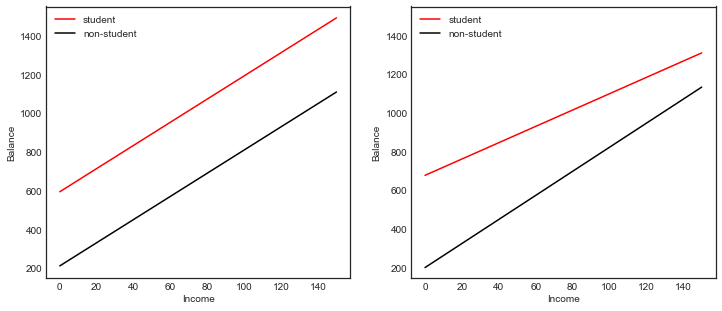

In [139]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)
    
#General question: the figures all look like blurry png's, 
#no way to get high quality vector graphics?

-------------------------------------------------------------
### 6.2 Model Complexity

Compare the following models:

In [140]:
advertising = pd.read_csv('../data/Advertising.csv', usecols=[1,2,3,4])
np.set_printoptions(3)

est1 = smf.ols('Sales ~ TV', advertising).fit()
print(r'$R^2=${:1.3f}'.format(est1.rsquared))

advertising["TV2"] = advertising.TV**2
est2 = smf.ols('Sales ~ TV + TV2', advertising).fit()
print(r'$R^2=${:1.3f}'.format(est2.rsquared))

advertising["TV3"] = advertising.TV**3
est3 = smf.ols('Sales ~ TV + TV2 + TV3', advertising).fit()
print(r'$R^2=${:1.3f}'.format(est3.rsquared))

advertising["TV4"] = advertising.TV**4
est3 = smf.ols('Sales ~ TV + TV2 + TV3 + TV4', advertising).fit()
print(r'$R^2=${:1.3f}'.format(est3.rsquared))

$R^2=$0.612
$R^2=$0.619
$R^2=$0.622
$R^2=$0.623


### 6.2.1 Overfitting

Can we "play this game" indefinitely?
Check graphically:

In [141]:
#sns.regplot('TV', 'Sales', data=advertising,fit_reg=True, order=10)
fit = np.polyfit(advertising.TV, advertising.Sales,2)

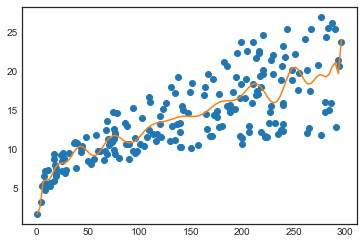

In [142]:
from numpy.polynomial import Polynomial
plt.plot(advertising.TV, advertising.Sales, "o")
p = Polynomial.fit(advertising.TV, advertising.Sales, 25)
plt.plot(*p.linspace())


How do we quantify the notion of **overfitting**, i.e. the (obvious?) impression that the model is "too wiggly", or **too complex** ?

The $R^2$ on the data we used to fit the model is useless for this purpose because it seems to only improve the more complex the model becomes!

One useful idea seems the following: if the orange line does not really capture the "true model", i.e. has adapted too much to the noise, its performance on a test set would be worse than a simpler model.

![p.81](figures/ISLR-Fig2.10.png)

Let us examine this idea by using a

### 6.2.2 Train Test Split

In [143]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = advertising.drop(["Sales", "Radio", "Newspaper"], axis=1).values
y = advertising.Sales
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)



#### 6.2.3 Tasks

1. Compare the $R^2$ and *rmse* for the quadratic and quartic models on the test data
2. Boston housing data
    * Compute the $R^2$ for the test portion 
    * Compare with the adjusted $R^2$.
    * Think about the model complexity parameter in OLS. 
    * How would one choose which variables should be part of the model?


R^2: 0.6559372890924903


0.386

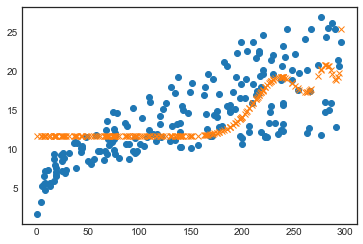

In [145]:
#cannot get the following to work
p,stats = Polynomial.fit(advertising.TV, advertising.Sales, 25, full=True)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=25)
X = poly.fit_transform(advertising.TV.values.reshape(-1, 1))
regr = skl_lm.LinearRegression().fit(X, advertising.Sales)
yHat = regr.intercept_+ np.dot(X,regr.coef_)
plt.plot(advertising.TV, advertising.Sales, "o")
plt.plot(advertising.TV, yHat, "x")
#
np.corrcoef(yHat, advertising.Sales)[0,1]**2


##### Boston Housing Data

In [146]:
boston = pd.read_csv('../data/boston.csv')
print(boston.head())
X = boston.drop('medv', axis=1).values
y = boston['medv'].values

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [147]:
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

In [148]:
#I wished I could use the short formula mdev ~ .
est = smf.ols('medv ~ crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+black+lstat', boston).fit()
est.summary()#.tables[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 21 Nov 2018   Prob (F-statistic):          6.72e-135
Time:                        09:20:07   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.000      26.432      46.487
crim          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
zn             0.0464      0.014      3.382      0.001       0.019       0.073
indus          0.0206      0.061      0.334      0.738      -0.100       0.141
chas           2.6867      0.862      3.118      0.002       0.994       4.380
nox          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
rm             3.8099      0.418      9.116      0.000       2.989       4.631
age            0.0007      0.013      0.052      0.958      -0.025       0.027
dis           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
rad            0.3060      0.066      4.613      0.000       0.176       0.436
tax           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
ptratio       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
black          0.0093      0.003      3.467      0.001       0.004       0.015
lstat         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



R^2: 0.711226005748498
Root Mean Squared Error: 4.638689926172782


![p.81](figures/ISLR-cvboot-Fig1.png)

### 6.3 Cross Validation

##### Drawbacks of validation set approach

- The validation estimate of the test error can be highly variable, depending on precisely which observations are included in the training/validation set.
- In the validation approach, only a subset of the observations - those that are included in the training set rather than in the validation set - are used to fit the model.
- This suggests that the validation set error may tend to **overestimate the test error** for the model fit on the entire data set.

##### K-fold Cross-validation

- randomly divide the data into K equal-sized parts. We leave out part k, fit the model to the other K-1 parts (combined), and then obtain predictions for the left-out kth part.
- This is done in turn for each part $k = 1,2, \ldots, K$, and then the results are combined.



In [150]:
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(reg_all, X, y, cv=5)
print(cv_results)
#[ 0.63919994 0.71386698 0.58702344 0.07923081 -0.25294154]
np.mean(cv_results)

[ 0.639  0.714  0.587  0.079 -0.253]


0.353

#### Comments

- For non-equal fold sizes, we need to compute the weighted mean!
- Setting $K = n$ yields n-fold or **leave-one out cross-validation** (LOOCV).
- With least-squares linear or polynomial regression, an amazing shortcut makes the cost of LOOCV the same as that of a single model fit! The following formula holds:
$$
CV_n = \frac{1}{n} \sum{\left( \frac{y_i - \hat{y}_i}{1-h_i} \right)^2}
$$
where $\hat{y}_i$ is the ith fitted value from the original least
squares fit, and $h_i$ is the leverage (see ISLR book for details.) This is like the ordinary MSE, except the ith residual is divided by $1-h_i$.


#### 6.3.1 Tasks

- Sketch the code for your own CV function.
- Reproduce the left panel of Fig. 5.6, i.e. the right panel of Fig 2.9 from the ISLR book


![p.81](figures/ISLR-Fig2.9.png)